In [20]:
# All imports here 

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet as swn
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import pandas as pd
import os
import pandas as pd
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# imports for LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
from gensim.models import LdaModel



In [21]:
# Ensure nltk data is downloaded
nltk.download('wordnet')
nltk.download('stopwords')

# %% [2] Define preprocessing functions
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_basic(tweet):
    tweet = tweet.lower()
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user mentions
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove special characters
    tweet = re.sub(r'\W', ' ', tweet)
    # Remove digits
    tweet = re.sub(r'\d', ' ', tweet)

    return tweet

def preprocess_lemmatization(tweet):
    preprocess_basic(tweet)
    words = tweet.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)


def preprocess_stemming(tweet):
    preprocess_basic(tweet)
    words = tweet.split()
    words = [PorterStemmer().stem(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)


def preprocess_stopwords(tweet):
    preprocess_basic(tweet)
    words = tweet.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)


def preprocess_extended(tweet):
    tweet = preprocess_basic(tweet)
    tweet = preprocess_lemmatization(tweet)
    tweet = preprocess_stemming(tweet)
    tweet = preprocess_stopwords(tweet)
    return tweet



PREPROCESSING_METHODS = [preprocess_basic, preprocess_lemmatization, preprocess_stemming, preprocess_stopwords, preprocess_extended]




[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Thania\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thania\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# Loading the dataset

base_directory = 'CrisisLexT26-v1.0\CrisisLexT26'  # Update with the path of your directory
stop_words = set('english')  # Update with your list/set of stop words if you have any

all_tweets_df = pd.DataFrame()
# Load tweets from the folder structure and preprocess 
for folder_name in os.listdir(base_directory): 
    folder_path = os.path.join(base_directory, folder_name) 
    if os.path.isdir(folder_path): 
        tweets_csv_path = os.path.join(folder_path, f"{folder_name}-tweets_labeled.csv") 
         
        if os.path.exists(tweets_csv_path):  
            df = pd.read_csv(tweets_csv_path)  
            df['Topic'] = folder_name  
            all_tweets_df = pd.concat([all_tweets_df, df], ignore_index=True)

relevant_info = ['Related - but not informative', 'Related and informative']
all_tweets_df = all_tweets_df[all_tweets_df[' Informativeness'].isin(relevant_info)]

      


In [23]:

def cluster_data(all_tweets_df, n_clusters=20):
    vectorizer = TfidfVectorizer(min_df=5, max_df=0.85, stop_words='english', ngram_range=(1, 2))
    X = vectorizer.fit_transform(all_tweets_df['Processed_Tweet'].values)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    all_tweets_df['predicted_label'] = kmeans.labels_

    # Creating a mapping between true labels and predicted clusters
    label_map = {}
    for cluster in range(n_clusters):
        sub_df = all_tweets_df[all_tweets_df['predicted_label'] == cluster]
        if not sub_df.empty:
            label_map[cluster] = sub_df['Topic'].value_counts().idxmax()
    all_tweets_df['predicted_topic'] = all_tweets_df['predicted_label'].map(label_map)

    return X, all_tweets_df


In [24]:

results = {}


for method in PREPROCESSING_METHODS:
    print(f"Using preprocessing method: {method.__name__}")
    
    # Preprocess the data using the current method
    all_tweets_df['Processed_Tweet'] = all_tweets_df[' Tweet Text'].apply(method)
    
    # Cluster the data and get X, all_tweets_df
    X, all_tweets_df = cluster_data(all_tweets_df)
    
    # Evaluate and store results
    accuracy = accuracy_score(all_tweets_df['Topic'], all_tweets_df['predicted_topic'])
    ari = adjusted_rand_score(all_tweets_df['Topic'], all_tweets_df['predicted_topic'])
    nmi = normalized_mutual_info_score(all_tweets_df['Topic'], all_tweets_df['predicted_topic'])
    silhouette = silhouette_score(X, all_tweets_df['predicted_label'])
    results[method.__name__] = {
        "Accuracy": accuracy,
        "ARI": ari,
        "NMI": nmi,
        "Silhouette": silhouette
    }


Using preprocessing method: preprocess_basic


c:\Users\Thania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Using preprocessing method: preprocess_lemmatization


c:\Users\Thania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Using preprocessing method: preprocess_stemming


c:\Users\Thania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Using preprocessing method: preprocess_stopwords


c:\Users\Thania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Using preprocessing method: preprocess_extended


c:\Users\Thania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [25]:

for method, metrics in results.items():
    print(f"Results for {method}:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value*100:.2f}%")
    print("\n")

    

Results for preprocess_basic:
Accuracy: 51.78%
ARI: 16.88%
NMI: 64.14%
Silhouette: 2.42%


Results for preprocess_lemmatization:
Accuracy: 50.21%
ARI: 18.67%
NMI: 63.75%
Silhouette: 2.30%


Results for preprocess_stemming:
Accuracy: 50.10%
ARI: 18.88%
NMI: 61.87%
Silhouette: 2.34%


Results for preprocess_stopwords:
Accuracy: 47.34%
ARI: 19.43%
NMI: 64.25%
Silhouette: 2.40%


Results for preprocess_extended:
Accuracy: 49.60%
ARI: 18.40%
NMI: 62.96%
Silhouette: 2.56%




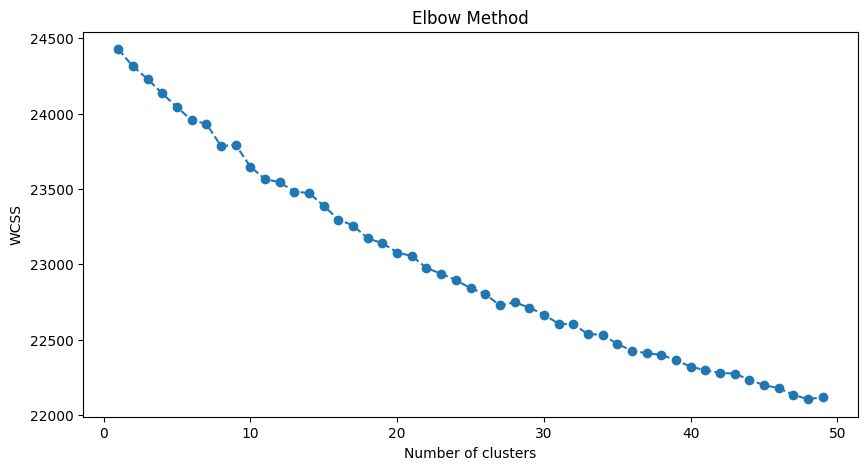

In [26]:
import matplotlib.pyplot as plt

def determine_optimal_clusters(data):
    wcss = []
    max_clusters = 50 # I'm setting a limit, but you might want to increase or decrease based on your requirements
    
    for i in range(1, max_clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        
    plt.figure(figsize=(10,5))
    plt.plot(range(1, max_clusters), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

# Preprocessing using preprocess_stopwords as it provided the best result previously
all_tweets_df['Processed_Tweet'] = all_tweets_df[' Tweet Text'].apply(preprocess_stopwords)
all_tweets_df.dropna(subset=['Processed_Tweet'], inplace=True)

vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(all_tweets_df['Processed_Tweet'].values)

determine_optimal_clusters(X)




In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
from gensim.models import LdaModel

tokens = [word_tokenize(doc) for doc in all_tweets_df['Processed_Tweet']]
tokens = [[word for word in doc if word not in stop_words] for doc in tokens]

# Create Gensim dictionary
dictionary = Dictionary(tokens)

# Convert your tokenized texts to a bag-of-words format
corpus = [dictionary.doc2bow(text) for text in tokens]

vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, stop_words='english', ngram_range=(1, 2))
text_tfidf = vectorizer.fit_transform(all_tweets_df['Processed_Tweet'].values)


lda_gensim = LdaModel(corpus, num_topics=26, id2word=dictionary, passes=15)

lda = LatentDirichletAllocation(random_state=42)
lda.fit(text_tfidf)

# Print topics
for index, topic in lda_gensim.print_topics(-1):
    print(f"Topic #{index + 1}")
    print(topic)




In [ ]:
from sklearn.decomposition import NMF

n_topics = 26

# Apply NMF
nmf = NMF(n_components=n_topics, random_state=42, l1_ratio=.5).fit(text_tfidf)

# Print the topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))



Topic #1:
colorado flooding springs colorado springs floods wildfire colorado floods colorado flooding http wildfires
Topic #2:
costa rica costa rica terremoto costa tsunami terremoto rica http alerta alerta tsunami quake
Topic #3:
bangladesh collapse building building collapse toll death death toll bangladesh building factory factory collapse
Topic #4:
brazil nightclub nightclub brazil praying affected sad hear sad tragedy praying brazil tragedy hear nightclub ddlovato sad
Topic #5:
new york new york york train train city derailed york city derailed new train derailed
Topic #6:
helicopter glasgow helicopter crash crash pub glasgow helicopter clutha police crash glasgow police helicopter
Topic #7:
tren santiago accidente compostela santiago compostela españa del accidente tren tren santiago tren españa
Topic #8:
typhoon haiyan philippines typhoon haiyan bopha typhoon bopha pablo typhoon pablo http super
Topic #9:
texas explosion plant fertilizer west fertilizer plant west texas plant e

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

# Extract top words for each NMF topic
top_words = []
feature_names = vectorizer.get_feature_names_out()
for topic in nmf.components_:
    top_word_indices = topic.argsort()[-10:][::-1]  # You can change 10 to any other number
    top_words.append([feature_names[i] for i in top_word_indices])

# Compute coherence for NMF topics
texts = tokens
nmf_topics = [[dictionary.token2id[word] for word in topic if word in dictionary.token2id] for topic in top_words]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_gensim, texts=tokens, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score for LDA: ', coherence_lda)

coherence_model_nmf = CoherenceModel(topics=nmf_topics, texts=tokens, dictionary=dictionary, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print('\nCoherence Score for NMF: ', coherence_nmf)



Coherence Score for LDA:  0.5457725002980869

Coherence Score for NMF:  0.5272303823040813
